Importation des packets.

In [1]:
import numpy as np
from scipy.stats import norm
from sklearn import datasets
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
from sklearn import linear_model
import os

cwd = os.getcwd()

dirname = "../srcimages/"
if not os.path.exists(dirname):
    os.mkdir(dirname)
imageformat = '.pdf'

def my_saving_display(fig, dirname, filename, imageformat):
    """"saving faster"""
    dirname + filename + imageformat
    image_name = dirname + filename + imageformat
    fig.savefig(image_name)

Importation de la base de données ''diabetes''.

In [2]:
datasets.load_diabetes()

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data
diabetes_y = diabetes.target

Les variables sont standardisées de la façon suivante:

In [3]:
print(diabetes_X.sum(axis = 0))
print(np.dot(np.transpose(diabetes_X),diabetes_X))

[-1.60635394e-13  5.78287418e-14 -3.55604435e-13  5.66491298e-14
 -3.90520949e-14  5.86544702e-14 -2.02199368e-13  1.66956726e-13
 -1.69323756e-13 -1.50849385e-13]
[[ 1.          0.1737371   0.18508467  0.33542671  0.26006082  0.21924314
  -0.07518097  0.2038409   0.27077678  0.30173101]
 [ 0.1737371   1.          0.0881614   0.24101317  0.03527682  0.14263726
  -0.37908963  0.33211509  0.14991756  0.20813322]
 [ 0.18508467  0.0881614   1.          0.39541532  0.24977742  0.26116991
  -0.36681098  0.4138066   0.44615865  0.38867999]
 [ 0.33542671  0.24101317  0.39541532  1.          0.24246971  0.18555783
  -0.17876121  0.25765337  0.39347814  0.39042938]
 [ 0.26006082  0.03527682  0.24977742  0.24246971  1.          0.89666296
   0.05151936  0.54220728  0.51550076  0.32571675]
 [ 0.21924314  0.14263726  0.26116991  0.18555783  0.89666296  1.
  -0.19645512  0.65981689  0.3183534   0.29060038]
 [-0.07518097 -0.37908963 -0.36681098 -0.17876121  0.05151936 -0.19645512
   1.         -0.738

Regression avec sk learn

In [4]:
regr = linear_model.LinearRegression()
regr.fit(diabetes_X , diabetes_y)

print(regr.coef_)
print(regr.intercept_)

[ -10.01219782 -239.81908937  519.83978679  324.39042769 -792.18416163
  476.74583782  101.04457032  177.06417623  751.27932109   67.62538639]
152.1334841628965


Premier graphe

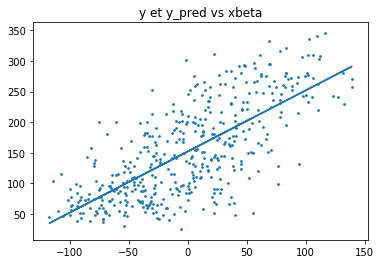

In [5]:
ypred_tmp = np.dot(diabetes_X , regr.coef_ )
ypred = ypred_tmp +  regr.intercept_ 
#ypred = regr.predict(diabetes_X)


plt.figure() 
plt.plot(ypred_tmp , ypred)
plt.scatter(ypred_tmp , diabetes_y , s =3 )
plt.title("y et y_pred vs xbeta")
plt.show()


Méthode Forward : à chaque boucle sur k, on selectionne la variable avec la plus grande p-valeur

In [7]:
diabetes_X_aug = np.column_stack( (np.ones( (diabetes_X.shape[0], 1 )), diabetes_X )) 

p = diabetes_X_aug.shape[1]
n = diabetes_X_aug.shape[0]

test = np.zeros((p,p))
pval_mem = np.zeros(p)
pval = np.zeros((p,p))
resids = diabetes_y

var_sel = []
var_remain = list(range(p))
in_test = []


regr = linear_model.LinearRegression(fit_intercept = False)


for k in range(p): 
    resids_mem = np.zeros((p,n))

    for i in var_remain:
        xtmp = diabetes_X_aug [:,[i]]
        regr.fit(xtmp , resids)
        
        #calcul de (x'x)
        xx = np.sum( diabetes_X_aug [:,[i]] ** 2 )    
        resids_mem [i,:] = regr.predict(xtmp) - resids
        sigma2_tmp = np.sum (resids_mem [i,:] ** 2) / xx
        test[k,i] = np.sqrt(n) * np.abs(regr.coef_) / (np.sqrt( sigma2_tmp )) 
        pval[k,i] =   2 * (1 - norm.cdf(test[k,i]))

    ####separe en deux vecteurs la listes des variables séléctionnées et les autres
    best_var = np.argmax(test[k,:])
    var_sel.append(best_var)
    resids = resids_mem[best_var,:]
    pval_mem [k] = pval[k,best_var]
    print(pval_mem [k])
    var_remain = np.setdiff1d(var_remain,var_sel)



0.0
0.0
0.0
0.009998414155584001
0.0013884647764106361
0.025121713715907656
0.0683653207566719
0.6408336315932897
0.7662203608739433
0.8486989784500079
0.9885844034605282


Pour les 3 premières étapes de la méthode (k=0,1,2), on trace les valeurs de la statistique de test calculée, enregistrée dans la matrice test.

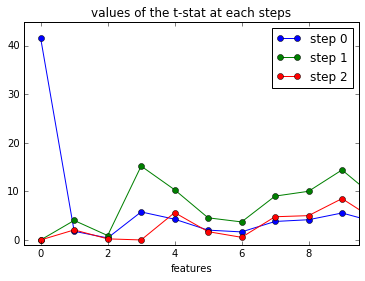

In [6]:
def foo(s1):
    return "step %s" % s1

fig = plt.figure()
for k in range(3): 
    lab_tmp = foo(k)
    plt.plot(np.arange(p),test[k,:], '-o',label = lab_tmp)
    plt.axis(xmin = -.5,xmax = 9.5,ymin = -1)
plt.legend(loc=1)
plt.title("values of the t-stat at each steps")
plt.xlabel("features")
plt.show()

filename = 'forw_first_steps'
my_saving_display(fig, dirname, filename, imageformat)


On peut maintenant regarder, pour chaque étape, la pvaleurs associée à la variable séléctionnée. On voit que cette pvaleur grandie; et que si l'on se fixe un niveau de 0.1 pour le test, on rejette l'hypothèse nulle (H_0 : beta_k = 0) uniquement pour les 6 premières étapes.

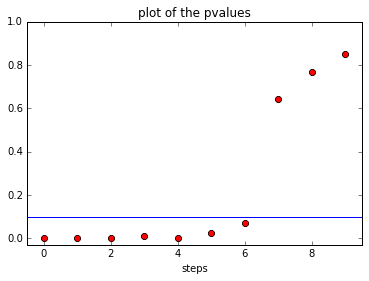

In [7]:
fig2 = plt.figure() 
for k in range(3): 
    plt.plot(np.arange(p),pval_mem, 'o')
    plt.plot([-0.5,9.5],[.1,.1],color = "blue" )
    plt.axis(xmin = -.5,xmax = 9.5,ymin = -.03)
plt.title("plot of the pvalues")
plt.xlabel("steps")
plt.show()

filename = 'pvalues'
my_saving_display(fig2, dirname, filename, imageformat)

En pratique cela signifie que notre méthode sélectionne les 7 variables suivantes (0 correspondant à l'intercept):

In [8]:
print("variables sélectionnées (dans l'ordre): " , 
      np.array(var_sel)[pval_mem<.1])

variables sélectionnées (dans l'ordre):  [0 3 9 5 4 2 7]


In [9]:
diabetes_X_aug = np.column_stack( (np.ones( (xtmp.shape[0], 1 )), diabetes_X )) 